In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pickle

import emcee
from multiprocess import Pool
from getdist import plots, MCSamples

In [10]:
def give_cl_cmb(ell, r=0, Alens=1.):
        
    power_spectrum = hp.read_cl('/home/nahue-ofi/CMM-Pipeline/src/data/Cls_Planck2018_lensed_scalar.fits')[:,:4000]
    if Alens != 1.:
        power_spectrum[2] *= Alens
    if r:
        power_spectrum += r * hp.read_cl('/home/nahue-ofi/CMM-Pipeline/src/data/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits')[:,:4000]
    return np.interp(ell, np.arange(1, 4001, 1), power_spectrum[2])

with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_cmb_d0_100_143_planck_parametric_d0_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
    data = pickle.load(f)

with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_cmb_d0_fullHFI_planck_parametric_d0_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
    data = pickle.load(f)
    
# with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
#     data = pickle.load(f)

# with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_cmbseed1_50reals_nofg.pkl', 'rb') as f:
#     datanofg = pickle.load(f)

_f = data['ell'] * (data['ell'] + 1) / (2 * np.pi)

print(data.keys())
print(np.shape(data['DlBB_i']))
nreals = np.shape(data['DlBB_i'])[0]

dict_keys(['ell', 'DlBB_i', 'DlBB_i_res', 'DlBB_mean', 'DlBB_mean_res'])
(98, 2, 2, 16)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

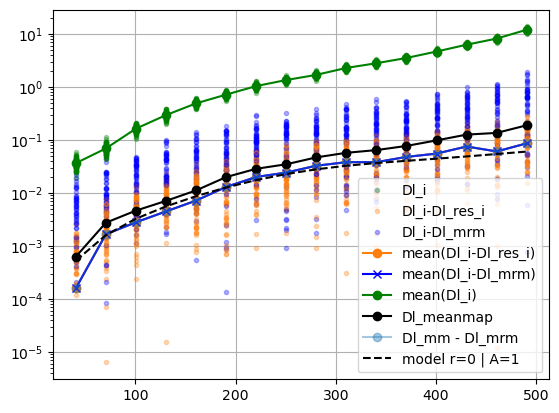

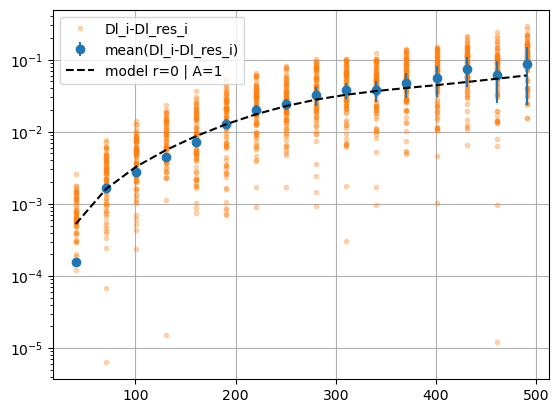

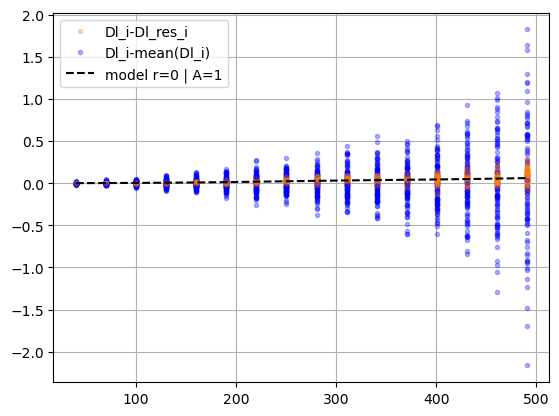

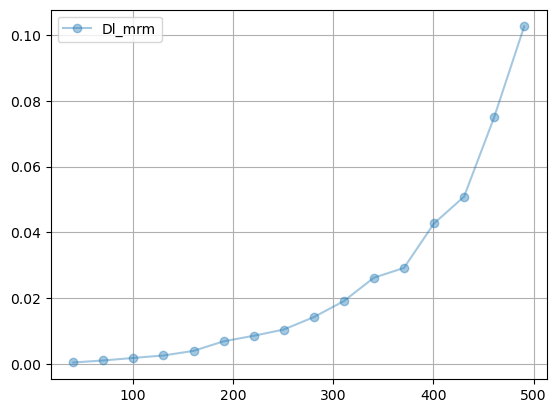

In [11]:
Alens = 2.5
r = 0.007

plt.figure()

for i in range(nreals):
    if i==0:
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-Dl_mrm')
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3)



plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mm - Dl_mrm',alpha=0.4)
plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout


plt.figure()

for i in range(nreals):
    if i==0:
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)

plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),yerr = np.sqrt(len(data['DlBB_i'][:,0,0,0]))*np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0)**2,fmt='o',label='mean(Dl_i-Dl_res_i)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)



plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

plt.figure()

for i in range(nreals):
    if i==0:
        # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-mean(Dl_i)')
    # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3)



# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mm - Dl_mrm',alpha=0.4)
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

plt.figure()

# for i in range(nreals):
#     if i==0:
#         # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
#         plt.plot(data['ell'],data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
#         # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-mean(Dl_i)')
#     # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
#     plt.plot(data['ell'],data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
#     # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3)



# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
plt.errorbar( data['ell'], data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mrm', alpha=0.4)
# plt.plot(data['ell'], np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

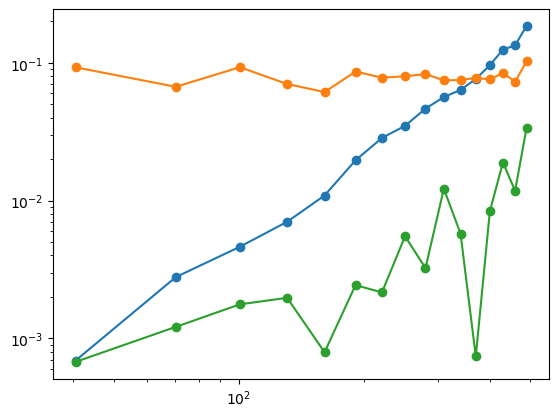

In [5]:
A=0.08
alpha=-0.01

plt.figure()
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = '-o', label = 'Dl_meanmap' )
plt.errorbar( data['ell'], data['DlBB_mean'][1,1,:], fmt = '-o', label = 'Dl_meanmap' )
plt.errorbar( data['ell'], np.abs(data['DlBB_mean'][0,1,:]), fmt = '-o', label = 'Dl_meanmap' )
# plt.errorbar( data['ell'], data['DlBB_mean'][1,0,:], fmt = '-o', label = 'Dl_meanmap' )
# plt.errorbar( data['ell'], A * (data['ell']/80)**alpha, fmt = '-o', label = 'Dl_meanmap' )

plt.yscale('log')
plt.xscale('log')

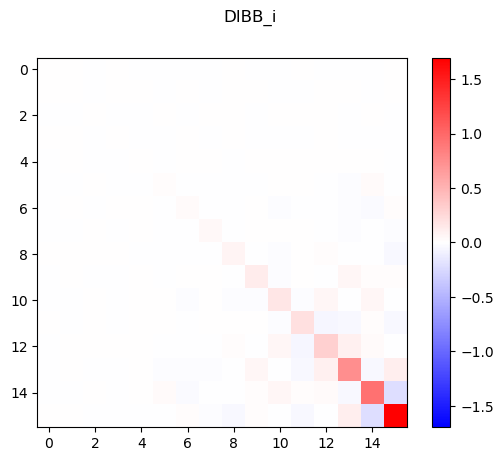

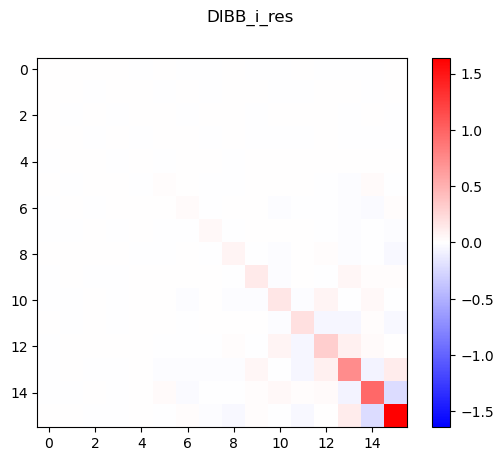

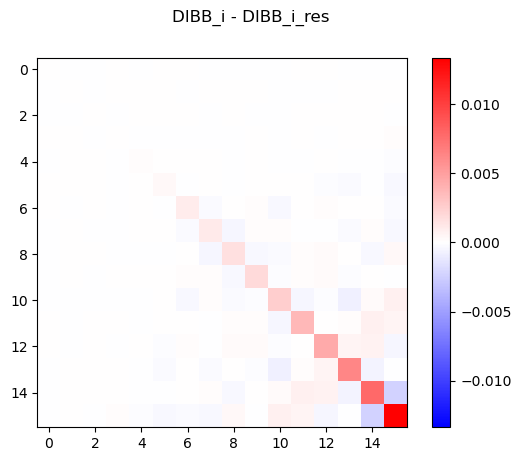

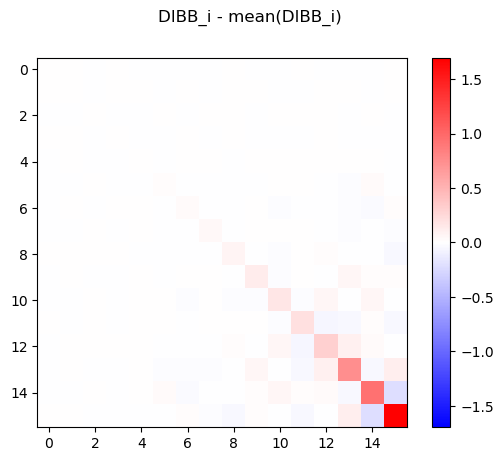

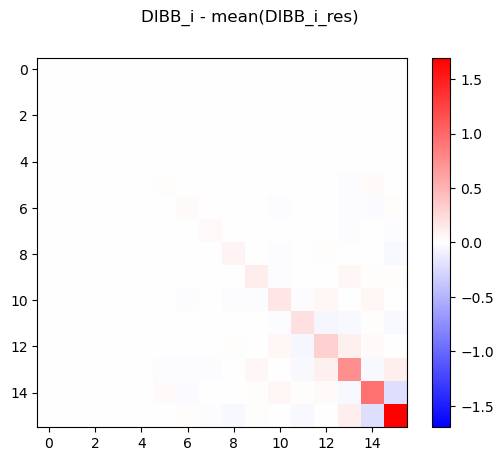

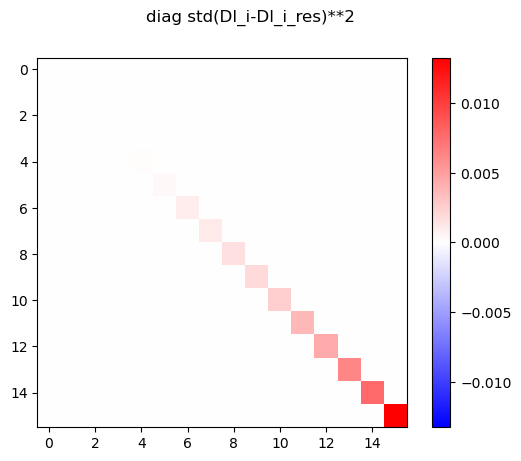

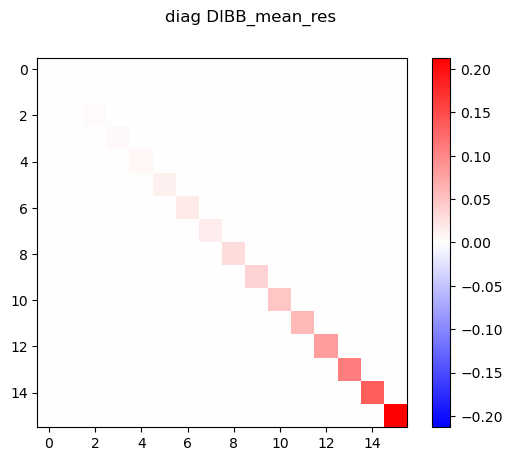

In [121]:
cov_cc_dli = np.cov( data['DlBB_i'][:, 0, 0,:], rowvar = False )
cov_cc = cov_cc_dli
plt.figure()
plt.suptitle('DlBB_i')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dlires = np.cov( data['DlBB_i_res'][:, 0, 0,:], rowvar = False )
cov_cc = cov_cc_dlires
plt.figure()
plt.suptitle('DlBB_i_res')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dli_dlires = np.cov( data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:], rowvar = False )
cov_cc = cov_cc_dli_dlires
plt.figure()
plt.suptitle('DlBB_i - DlBB_i_res')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dli_meandli = np.cov( data['DlBB_i'][:, 0, 0,:] - np.mean(data['DlBB_i'][:, 0, 0,:], axis = 0 ), rowvar = False)
cov_cc = cov_cc_dli_meandli
plt.figure()
plt.suptitle('DlBB_i - mean(DlBB_i)')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dli_meandlires = np.cov( data['DlBB_i'][:, 0, 0,:] - np.mean(data['DlBB_i_res'][:, 0, 0,:], axis = 0 ), rowvar = False)
cov_cc = cov_cc_dli_meandlires
plt.figure()
plt.suptitle('DlBB_i - mean(DlBB_i_res)')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_1, np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:], axis=0)**2)
cov_cc = cov_cc_diag_1
plt.figure()
plt.suptitle('diag std(Dl_i-Dl_i_res)**2')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_diag_2 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_2, data['DlBB_mean_res'][0,0,:])
cov_cc = cov_cc_diag_2
plt.figure()
plt.suptitle('diag DlBB_mean_res')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

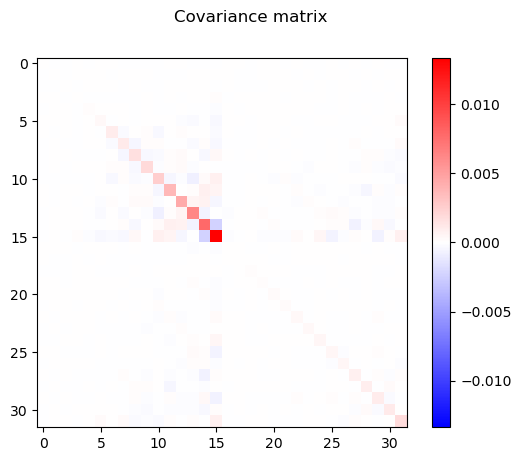

In [138]:
data_cmb = data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:]
data_dust = data['DlBB_i'][:, 1, 1,:] - data['DlBB_i_res'][:, 1, 1,:]

cov_cd = np.cov( data_cmb, data_dust, rowvar = False )

plt.figure()

plt.suptitle('Covariance matrix')
vmax = np.max(np.abs(cov_cd[:, :]))
plt.imshow(cov_cd[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

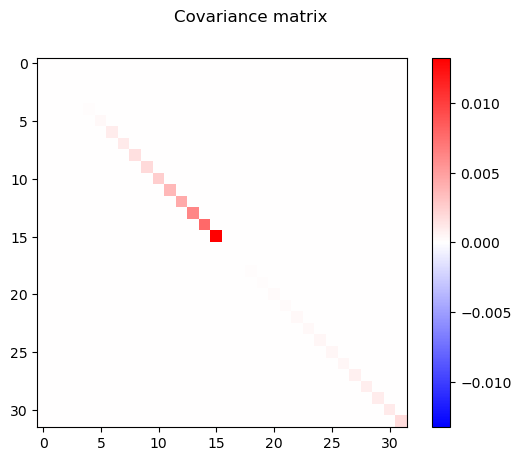

In [139]:
cov_cc_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_1, np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:], axis=0)**2)

cov_dd_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_dd_diag_1, np.std(data['DlBB_i'][:,1,1,:]-data['DlBB_i_res'][:,1,1,:], axis=0)**2)

cov_cc_dd_diag = np.zeros((32,32))

cov_cc_dd_diag[:16,:16] = cov_cc_diag_1
cov_cc_dd_diag[16:,16:] = cov_dd_diag_1

plt.figure()

plt.suptitle('Covariance matrix')
vmax = np.max(np.abs(cov_cc_dd_diag[:, :]))
plt.imshow(cov_cc_dd_diag[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [140]:
cov = cov_cd

cov_inv = np.linalg.inv(cov)

observation_meanmap = np.array([data['DlBB_mean'][0,0,:], data['DlBB_mean'][1,1,:]])
observation_unbiased = np.array([np.mean(data['DlBB_i'][:,0,0,:] - data['DlBB_i_res'][:,0,0,:], axis=0), np.mean(data['DlBB_i'][:,1,1,:] - data['DlBB_i_res'][:,1,1,:], axis=0)])

observation = observation_unbiased

In [141]:
like_components = 'cmb_dust'

cross_cov_cmb_dust = True

In [142]:
def foregrounds(ell, A, alpha):
    return A * (ell/80)**alpha
    
def log_prior(x):
    
    if like_components == 'cmb':

        r, Alens = x

        if r > 1 or r < -1:
            return -np.inf
    
        if Alens < 0.1 or Alens > 4:
            return -np.inf

    elif like_components == 'cmb_dust':
        
        r, Alens, A, alpha = x
        
        if r > 1 or r < -1:
            return -np.inf
    
        if Alens < 0.1 or Alens > 4:
            return -np.inf
    
        if alpha > 1 or alpha < -1:
           return -np.inf
    
        if A > 0.1 or A < -0.1:
           return -np.inf

    else:
        
        raise Exception('The components in the likelihood can be: cmb or cmb_dust')
        
    return 0

def like(x):

    nbins_ell = len(data['ell'])

    if like_components == 'cmb':

        r, Alens = x
        
        ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens)])
        yobs = observation[0]
        res = ymodel - yobs

        lp = log_prior(x)
        
        L_cmb_cmb = - 0.5 * ((res[0].T @ cov_cc_inv[:nbins_ell,:nbins_ell] @ res[0]))
        
        L = lp + L_cmb_cmb
        
    elif like_components == 'cmb_dust':

        r, Alens, A, alpha = x
        
        ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens), foregrounds(data['ell'], A, alpha)])
        yobs = observation
        res = ymodel - yobs

        lp = log_prior(x)
        
        L_cmb_cmb = - 0.5 * ((res[0].T @ cov_cc_inv[:nbins_ell,:nbins_ell] @ res[0]))
        L_dust_dust = - 0.5 * (res[1].T @ cov_cc_inv[nbins_ell:,nbins_ell:] @ res[1])

        if cross_cov_cmb_dust == True:
            
            L_dust_cmb = - 0.5 * (res[1].T @ cov_cc_inv[nbins_ell:,:nbins_ell] @ res[0])
            L_cmb_dust = - 0.5 * (res[0].T @ cov_cc_inv[:nbins_ell,nbins_ell:] @ res[1])
            
            L = lp + L_cmb_cmb + L_dust_cmb + L_cmb_dust + L_dust_dust
            
        else:
            
            L = lp + L_cmb_cmb + L_dust_dust
  
    return L

In [143]:
nwalkers = 30

if like_components == 'cmb':
    
    nparams = 2
    
    x0 = np.zeros((nwalkers, nparams))
    
    x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
    x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))   
    
elif like_components == 'cmb_dust':
    
    nparams = 4
    
    x0 = np.zeros((nwalkers, nparams))
    
    x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
    x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
    x0[:, 2] = np.random.normal(0.08, 0.005, (nwalkers))
    x0[:, 3] = np.random.normal(-0.01, 0.005, (nwalkers))

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, nparams, like, pool=pool)
    sampler.run_mcmc(x0, 3000)#, progress=True)

chains = sampler.get_chain()

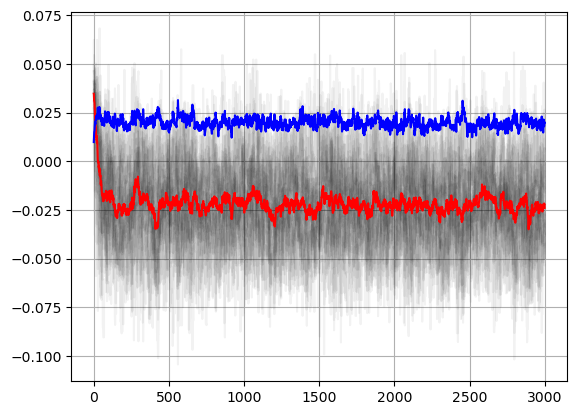

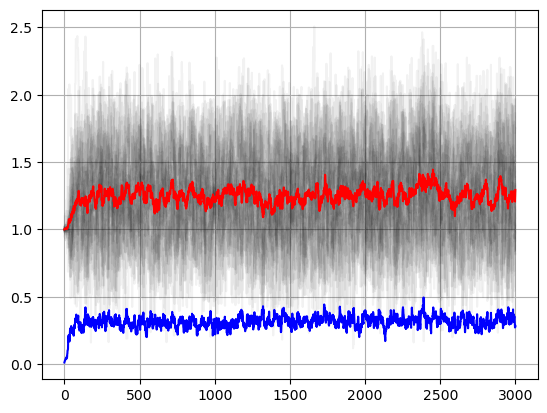

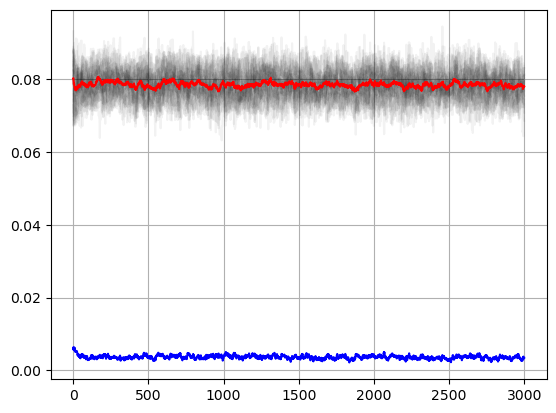

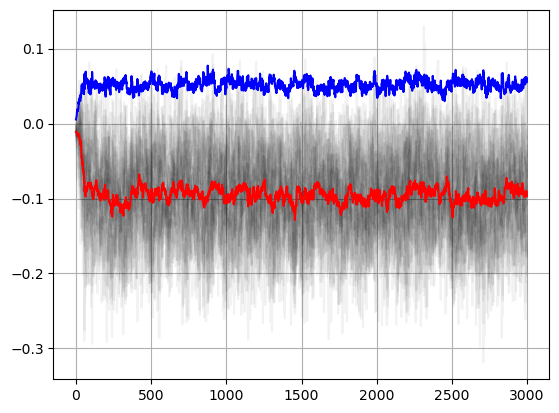

In [144]:
for j in range(nparams):
    
    plt.figure()
    
    for i in range(nwalkers):
        plt.plot(chains[:, i, j], '-k', alpha=0.05)
    plt.plot(np.mean(chains, axis=1)[:, j], '-r')
    plt.plot(np.std(chains, axis=1)[:, j], '-b')
    # plt.axhline(0, ls='--', color='black')
    # plt.axhline(0.015, ls='--', color='green')
    # plt.xlim(0, chains.shape[0])
    # plt.ylim(-0.05, 0.1)
    plt.grid()
    plt.tight_layout

In [145]:
chainflat = sampler.get_chain(discard=300, thin=15, flat=True)

Removed no burn in


<Figure size 1200x800 with 0 Axes>

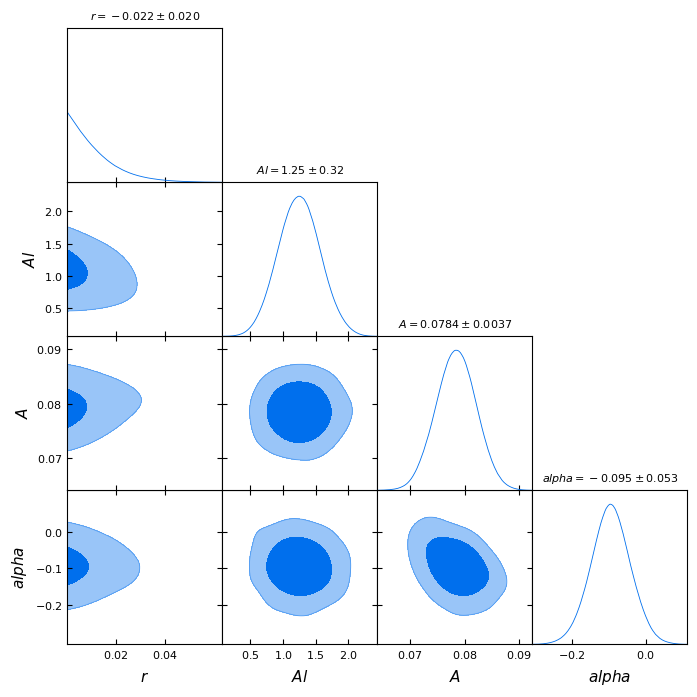

In [146]:
names_all = ['r','Al','A','alpha']

labels = []
names = []
for i in range(nparams):
    names += [f'{names_all[i]}']
    labels += [f'{names_all[i]}']
            
s = MCSamples(samples=chainflat, names=names, labels=labels, label=r'', ranges={'r':(0, None)})

plt.figure(figsize=(12, 8))

# Triangle plot
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([s], filled=True, title_limit=1)
plt.savefig('r_Alens_A_alpha_cov_cd_obs_unbiased')
plt.show()